<a href="https://colab.research.google.com/github/BachokunIAR/Parkinson/blob/main/brain_tumur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models,layers

In [3]:
from google.colab import drive
drive.mount("/content/drive")



Mounted at /content/drive


In [4]:
source_data_dir = "/content/drive/MyDrive/Data/brain_tumur/Train"
source_data_dir

'/content/drive/MyDrive/Data/brain_tumur/Train'

In [5]:
# Importigng the data
IMAGE_SIZE =256
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3

dataset_train = tf.keras.preprocessing.image_dataset_from_directory(source_data_dir,
                                                              shuffle = True,
                                                              image_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                              batch_size = BATCH_SIZE
                                                              )

Found 4737 files belonging to 4 classes.


In [6]:
class_names = dataset_train.class_names
class_names

['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

In [7]:
for image_batch, label_batch in dataset_train.take(1):
    print(image_batch[0].numpy())  # trurn the image  into a numpy array

[[[0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  ...
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]]

 [[0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  ...
  [0.5 0.5 0.5]
  [0.5 0.5 0.5]
  [0.5 0.5 0.5]]

 [[1.5 1.5 1.5]
  [1.5 1.5 1.5]
  [1.5 1.5 1.5]
  ...
  [2.5 2.5 2.5]
  [2.5 2.5 2.5]
  [2.5 2.5 2.5]]

 ...

 [[1.  1.  1. ]
  [1.  1.  1. ]
  [1.  1.  1. ]
  ...
  [1.5 1.5 1.5]
  [1.5 1.5 1.5]
  [1.5 1.5 1.5]]

 [[0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  ...
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]]

 [[0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  ...
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]]]


In [8]:
print(image_batch[0].shape)

(256, 256, 3)


# <font color =red> Visualizing the data

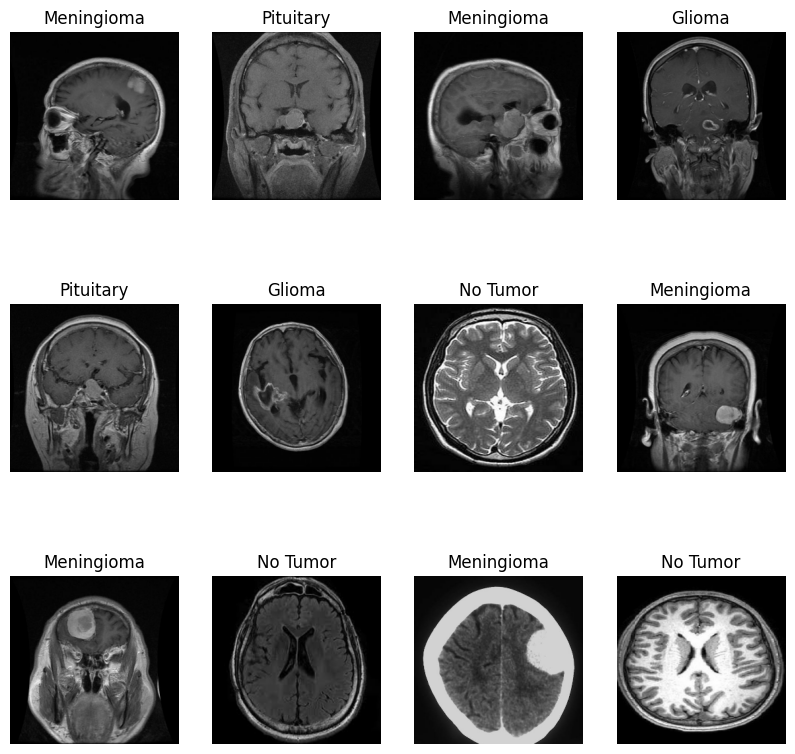

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset_train.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis(False)

# Validation dataset

In [10]:
validation_data_dir = "/content/drive/MyDrive/Data/brain_tumur/Val"
validation_data_dir

'/content/drive/MyDrive/Data/brain_tumur/Val'

In [11]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(validation_data_dir,
                                                              shuffle = False,
                                                              #image_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                              #batch_size = BATCH_SIZE
                                                              )

Found 522 files belonging to 4 classes.


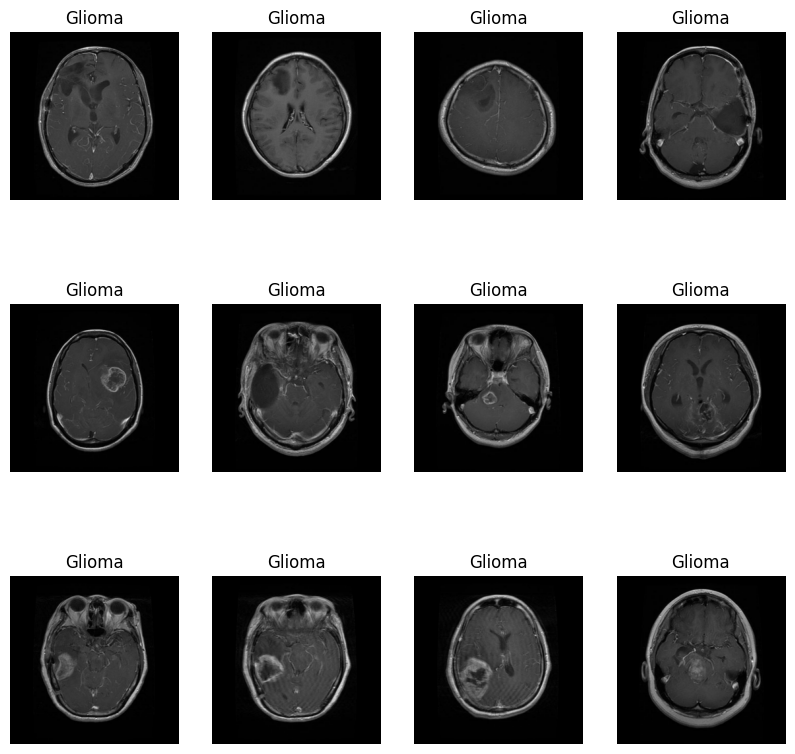

In [12]:
# I want to visualize the validation dataset
plt.figure(figsize=(10,10))
for image_batch, label_batch in val_dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis(False)

# Splitting data into Train, test and validation datasets

In [13]:
train_split = 0.8
len(dataset_train)*train_split

119.2

In [14]:
train_ds = dataset_train.take(119)
len(train_ds)

119

In [15]:
test_ds = dataset_train.skip(119)
len(test_ds)

30

In [16]:
val_size = val_dataset
len(val_size)

17

In [17]:
val_ds = val_size

# Writting a function for the splitting

In [18]:
def get_dataset_spltting(ds,
                         train_split = 0.8,
                         test_split = 0.2,
                         val_split = val_size,
                         shuffle = True,
                         shuffle_size = 10000):

  ds_size = len(ds)
  if shuffle:
      ds = ds.shuffle(shuffle_size ,seed = 42)

  train_size = int(train_split*ds_size)
  val_size = int(val_split)

  train_ds = ds.take(train_size)
  val_ds = val_size

  test_ds = ds.skip(train_size)

  return train_ds, val_ds, test_ds

In [19]:
#train_ds,val_ds, test_ds = get_dataset_spltting(dataset_train)

In [20]:
train_ds  = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds  = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds  = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [21]:
# Scaling the
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [22]:
# generating more sqample by applying rotation, zoom etc.
#This is usually apply when the scientist does not have eneough data to train a model. about four to five more image can be geberated from on image which add to incre=ase the datasize
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [23]:
# Buildeing the model

IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 30
CHANNELS = 3

input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation= 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size= (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size= (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size= (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size= (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size= (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation= 'relu'),
    layers.Dense(n_classes, activation= 'softmax'),

])

model.build(input_shape = input_shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 4)                     │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,812 (718.02 KB)

 Trainable params: 183,812 (718.02 KB)

 Non-trainable params: 0 (0.00 B)

# <font color = red> Showing 2D plot of the model

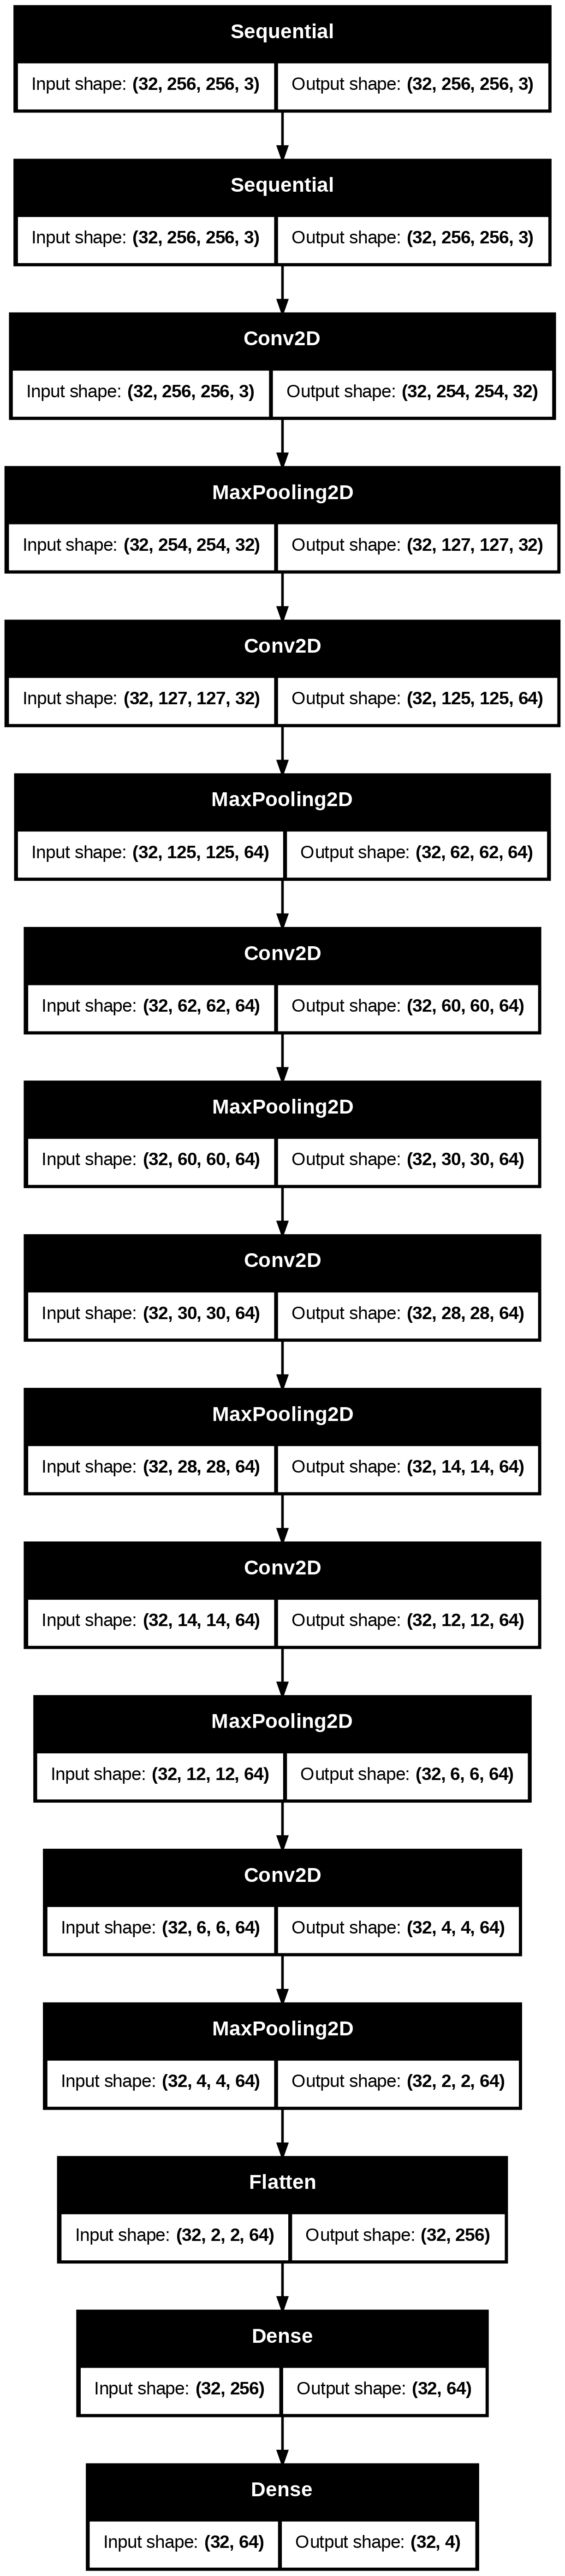

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [29]:
# Compilling the model

model.compile(
    optimizer= "Adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ["accuracy"]
              )

In [27]:
# Training the model
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = True,
    validation_data = val_ds)

Epoch 1/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 929s 5s/step - accuracy: 0.4348 - loss: 1.2365 - val_accuracy: 0.5441 - val_loss: 0.9675
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 573s 5s/step - accuracy: 0.6392 - loss: 0.9115 - val_accuracy: 0.6686 - val_loss: 0.8421
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 581s 5s/step - accuracy: 0.6881 - loss: 0.8025 - val_accuracy: 0.6762 - val_loss: 0.8130
Epoch 4/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 579s 5s/step - accuracy: 0.7085 - loss: 0.7336 - val_accuracy: 0.6916 - val_loss: 0.7028
Epoch 5/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 579s 5s/step - accuracy: 0.7233 - loss: 0.6745 - val_accuracy: 0.7452 - val_loss: 0.6243
Epoch 6/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 581s 5s/step - accuracy: 0.7514 - loss: 0.6010 - val_accuracy: 0.7835 - val_loss: 0.5500
Epoch 7/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 629s 5s/step - accuracy: 0.7797 - loss: 0.5390 - val_accuracy: 0.7912 - val_loss: 0.4928
Epoch 8/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 588s 5s/step - accuracy: 0.7982 - loss: 0.5048 - val_accu

In [30]:
scores = model.evaluate(test_ds)

30/30 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9382 - loss: 0.2118


In [31]:
scores

[0.1726570874452591, 0.9429494142532349]

In [32]:
history.params

{'verbose': True, 'epochs': 30, 'steps': 119}

In [33]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [34]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]


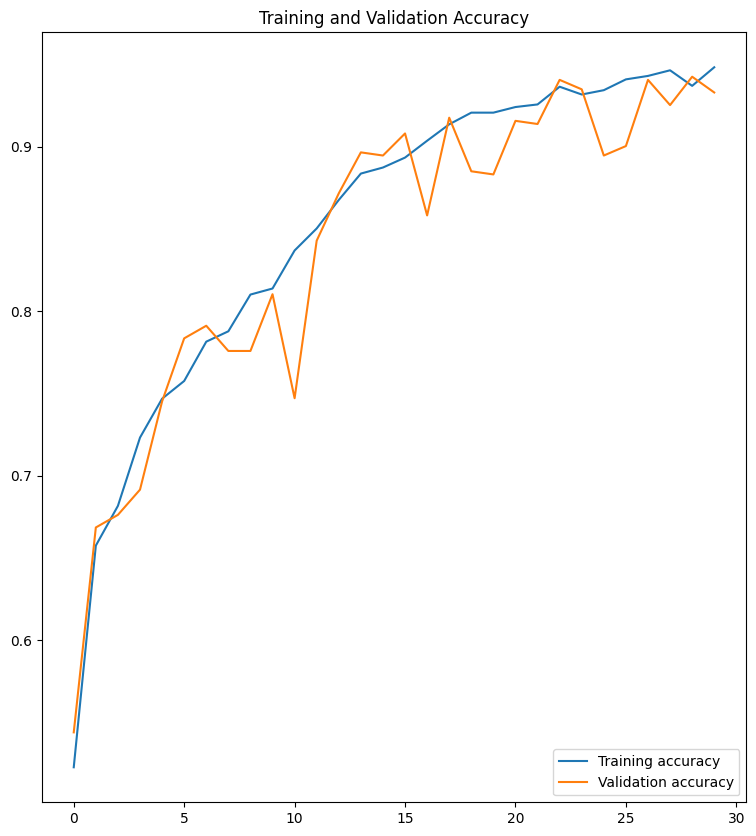

In [35]:
plt.figure( figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label ='Training accuracy')
plt.plot(range(EPOCHS), val_acc, label ='Validation accuracy')
plt.legend(loc = 'lower right')
plt.title( "Training and Validation Accuracy");

Text(0.5, 1.0, 'Training and Validation Accuracy')

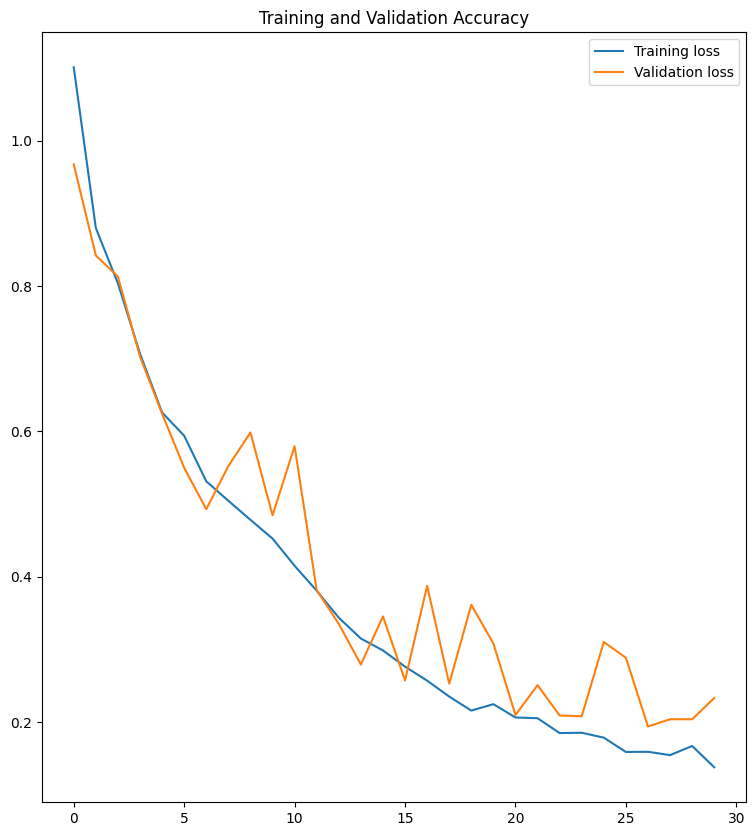

In [36]:
plt.figure( figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label ='Training loss')
plt.plot(range(EPOCHS), val_loss, label ='Validation loss')
plt.legend(loc = 'upper right')
plt.title( "Training and Validation Accuracy")


fisrt image to be predicted 
actual label :  Glioma
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
predicted label Pituitary


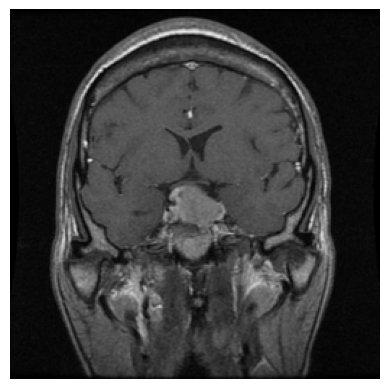

In [37]:
for images_batch, labele_batch in test_ds.take(1):
  plt.imshow(images_batch[0].numpy().astype('uint8'))
  plt.axis(False)
  first_image = images_batch[0].numpy().astype("uint8")
  first_label = label_batch[0].numpy()
  print("fisrt image to be predicted ")
  plt.imshow(first_image)
  print("actual label : ", class_names[first_label])
  batch_prediction = model.predict(images_batch)
  print("predicted label",class_names[np.argmax(batch_prediction[0])])

# Creating a function to do the prediction

In [38]:
def predict(model, img):
  img_array  = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0) # create a batch

  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100*(np.max(predictions[0])),2)
  return predicted_class, confidence

## Visualising the predicted data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


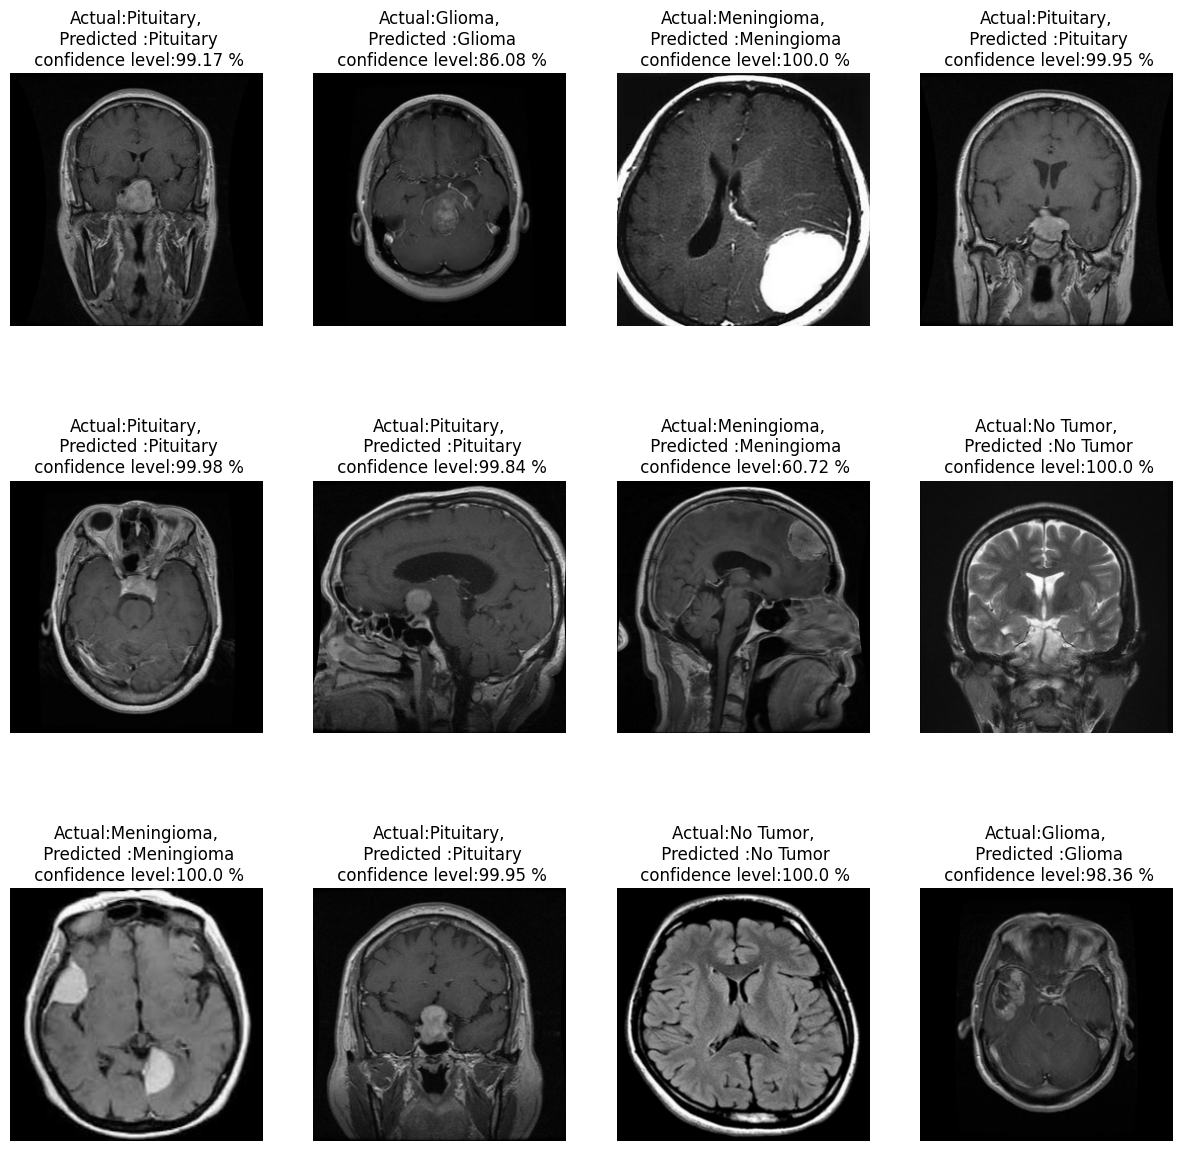

In [39]:
plt.figure(figsize=(15,15))

for images, labels in test_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f"Actual:{actual_class},\n Predicted :{predicted_class}\n confidence level:{confidence} %")
    plt.axis(False);


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


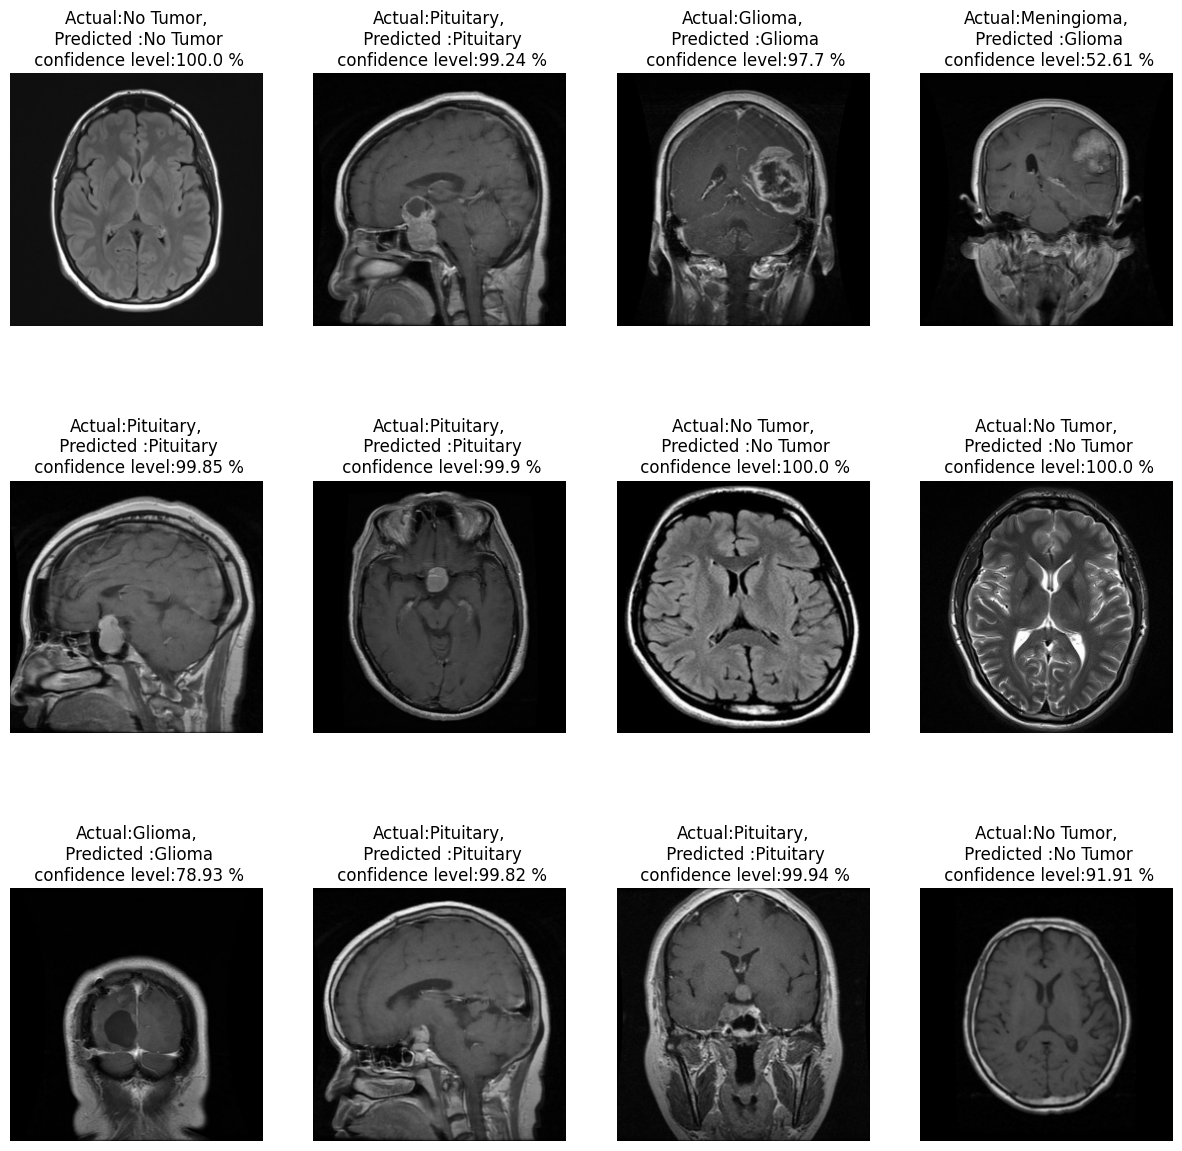

In [40]:
plt.figure(figsize=(15,15))

for images, labels in test_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f"Actual:{actual_class},\n Predicted :{predicted_class}\n confidence level:{confidence} %")
    plt.axis(False);

# Saving the model

In [42]:
# brain_model = 'brain_tumur'
# model.save(f"/content/drive/MyDrive/models/{brain_model}")